In [10]:
%load_ext autoreload
%reload_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [11]:
# preparing data
from os import path
from argparse import Namespace

from sklearn.manifold import TSNE
from datasetPreProcessing import LoadDatasetByName

from models import *
from methods import *

import namespace.AutoEncoderTester 

import pandas as pd
import torch
import os

#DATASET = 'ECU_IoHT_data'

DATASET = 'iiot_data'
#DATASET = 'iiot_data_h'
#DATASET = 'TON_IoT_full_data'
#DATASET = 'TON_IoT_data'
#DATASET = 'creditcard_data'
#DATASET = 'full_data'
#DATASET = 'medical_data'
#DATASET = 'network_data_h'
#DATASET = 'KDD_10'
"""___________________Hyper Parameters________________________"""
# a bad practice, only for testing purpose
globals().update(vars(Namespace(**namespace.AutoEncoderTester.ns)))
"""___________________________________________________________"""
# Load Dataset
raw_data, anomalous_raw, features, categorical_data_index = LoadDatasetByName(DATASET)
# check and load device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# 
specificity_list, recall_list = [], []
Enhanced_metrics = {'MCC':{}, 'Specificity':{}, 'Recall':{}}
print(raw_data.shape, anomalous_raw.shape)

(1107448, 43) (87016, 43)


In [12]:
import itertools
loop_count = 0

# Different types of model
torch.autograd.set_detect_anomaly(False)
for model_name in MODEL_NAME:
    # Data Processing
    for idc, trim_data, normalize_data, normalization_scheme, filter_corrcoef, remove_noise, noise_threshold in itertools.product(IDC, TRIM_DATA, NORMALIZE_DATA, NORMALIZATION_SCHEME, FILTER_CORRCOEF, REMOVE_NOISE, NOISE_THRESHOLD):
        # initialize containers for data
        loss_array = []
        # process data
        train_data, validation_data, test_data, anomalous_data = preProcessData_OneClass(raw_data, anomalous_raw, trim=trim_data, split=SPLIT, trim_threshold=0.98, normalize=normalize_data, normalization_scheme=normalization_scheme,
            filterLinearDependencies=filter_corrcoef, filter_threshold=0.98, removeNoise=remove_noise, noise_threshold=noise_threshold, return_dict=return_dict, discretize=False, categorical_data_index=categorical_data_index)
        # select feature
        if idc:
            train_data, validation_data, test_data, anomalous_data = train_data[:,idc], validation_data[:,idc], test_data[:,idc], anomalous_data[:,idc]
        num_feature = train_data.shape[-1]
        print(f'return dict: {return_dict}')
        train_data, validation_data, test_data, anomalous_data = toTorchTensor(device, train_data, validation_data, test_data, anomalous_data)
        if False:
            train_data, validation_data, test_data, anomalous_data = torch.matmul(train_data, lcs_weights), torch.matmul(validation_data, lcs_weights), torch.matmul(test_data, lcs_weights), torch.matmul(anomalous_data, lcs_weights)
        
        train_data = torch.concatenate((train_data, validation_data), dim=0)
        criterion = CRITERION
        print(train_data.shape, validation_data.shape, test_data.shape, anomalous_data.shape)
        
        for latent_dim, hidden_dim, activation, initialization, sigma in itertools.product(LATENT_DIM, HIDDEN_DIM, ACTIVATION, INITIALIZATION, SIGMA):
            for algo, learning_rate, weight_decay, epochs, batch_size, noise_factor, noise_fraction in itertools.product(GD_ALGORITHMS, LEARNING_RATE, WEIGHT_DECAY, EPOCHS, BATCH_SIZE, NOISE_FACTOR, NOISE_FRACTION):
                # initialize model
                """ attNet = None
                if ATTENTION:
                    attNet = AttentionNet(num_feature=num_feature, sample_size=len(train_data), E_dim=ATT_E_DIM)
                    num_feature = attNet.E_Dim
                if usePEA:
                    attNet = PEA(num_feature=num_feature, sample_size=len(train_data), latent_dim=16, num_projections=NUM_PROJECTION) """
                if model_name == 'AE':
                    model = AutoEncoder(num_feature=num_feature, latent_dim=latent_dim, hidden_dim=hidden_dim, activation=activation, initialization=initialization).to(device)
                elif model_name == 'DAE':
                    model = DAE(num_feature=num_feature, latent_dim=latent_dim, hidden_dim=hidden_dim, activation=activation, initialization=initialization, noise_factor=noise_factor, noise_fraction=noise_fraction).to(device)
                elif model_name == 'VAE':
                    model = VAE(num_feature=num_feature, latent_dim=latent_dim, hidden_dim=hidden_dim, activation=activation, initialization=initialization, sigma=sigma).to(device)
                elif model_name == 'SVAE':
                    model = SVAE(num_feature=num_feature, latent_dim=latent_dim, hidden_dim=hidden_dim, activation=activation, initialization=initialization, sigma=sigma).to(device)
                elif model_name == 'SAE':
                    model = SAE(num_feature=num_feature, latent_dim=latent_dim, hidden_dim=hidden_dim, activation=activation, initialization=initialization).to(device)
                elif model_name == 'RBM':
                    model = RBM(num_feature=num_feature, latent_dim=latent_dim, initialization=initialization).to(device)
                else:
                    model = None
                    
                print(model.name)
                # train 
                criterion.reduction = 'sum'
                #attNet = AttentionNet(num_feature=num_feature, sample_size=len(train_data))
                loss_array = train(model, 'SGD', epochs, train_data, train_data, criterion, batch_size=batch_size, lr=learning_rate, weight_decay=weight_decay
                    , grad_limit=GRAD_LIMIT, att=None)
                torch.save(model.state_dict(), '../model/param_'+model.name+'_'+DATASET)
                criterion.reduction = 'sum'
                print('00')
                """ if ATTENTION or usePEA:
                    train_data, test_data, anomalous_data = attNet.transformData(train_data), attNet.transformData(test_data), attNet.transformData(anomalous_data)
                    # test
                    loss_test, loss_attack, kl_div_test, kl_div_attack, y_scores, y_scores_lcs, y_ground_truth, lcs_array_test, lcs_array_attack = test(model, criterion, train_data, test_data, anomalous_data)  """
                #loss_test, loss_attack, kl_div_test, kl_div_attack, y_scores, y_scores_lcs, y_ground_truth, lcs_array_test, lcs_array_attack = test(model, criterion, train_data, test_data, anomalous_data) 
                loss_test, loss_attack = test_light(model, criterion, train_data, test_data, anomalous_data) 
                print('01')
                # t-SNE analysis of code distribution
                """ tsne = TSNE(n_components=2, perplexity=PERPLEXITY)
                full_code = model.encode(torch.cat((test_data_temp, anomalous_data_temp), dim=0)).detach().numpy()
                full_label = [0 for _ in range(len(test_data_temp))] + [1 for _ in range(len(anomalous_data_temp))]
                tsne_code = tsne.fit_transform(full_code) """
                # select reconstruction error threshold to classify
                criterion.reduction = 'none'
                """ 
                train_loss = torch.sum(criterion(model(train_data), train_data), dim=-1, keepdim=False)
                test_loss, attack_loss = torch.sum(criterion(model(test_data), test_data), dim=-1), torch.sum(criterion(model(anomalous_data), anomalous_data), dim=1) """
                print('0')
                train_loss, test_loss, attack_loss = getLoss(model, criterion, train_data, test_data, anomalous_data, weights=lcs_weights)
                print('1')
                # compute and save the standard deviation of Loss per feature
                """ lcs = criterion(model(train_data), train_data)# / train_loss.view(len(train_loss), 1)
                lcs_std = torch.std(lcs, dim=0, keepdim=False)
                i = 1
                path = '../LCS_std'
                filename = model.name
                pathfile = os.path.normpath(os.path.join(path, filename))
                if not os.path.exists(path):
                    os.makedirs(path)
                while os.path.isfile(pathfile + '.txt'):
                    pathfile = os.path.normpath(os.path.join(path, filename + str(i)))
                    i += 1
                np.savetxt(pathfile + '.txt', lcs_std.detach().numpy()) """
                print('2')
                sorted_loss, _ = torch.sort(train_loss)
                print('3')
                # threshold
                threshold_upper, threshold_lower = sorted_loss[math.floor(len(sorted_loss)*THRESHOLD_UPPER)], sorted_loss[math.floor(len(sorted_loss)*THRESHOLD_LOWER)]
                
                specificity = torch.sum(torch.logical_and((test_loss) <= threshold_upper, (test_loss) >= threshold_lower)) / len(test_data)
                recall = torch.sum(torch.logical_or((attack_loss) > threshold_upper, (attack_loss) < threshold_lower)) / len(anomalous_data)
                # plot
                # parameters for visualizer to print
                parameters = {"trim_data": trim_data, "normalize_data": normalize_data,
                              "normalization_scheme": normalization_scheme,
                    "filter_corrcoef": filter_corrcoef, "remove_noise": remove_noise, "noise_threshold": noise_threshold,
                    
                    "latent_dim": latent_dim, "hidden_dim": hidden_dim,
                    "activation": activation, "initialization": initialization,

                    "weight_decay": weight_decay,
                    "learning_rate": learning_rate,
                    "batch_size": batch_size,
                    "epochs": epochs,
                    
                    "threshold_upper": threshold_upper.item(), "threshold_lower": threshold_lower.item(),
                    "specificity": specificity,
                    "recall": recall,
                    
                    "attention": ATTENTION,
                    "PEA": usePEA,
                    }
                if idc:
                    parameters["feature_selected"] = idc[0]
                if model.name == 'VAE':
                    parameters["sigma"] = sigma
                if model.name == 'DAE':
                    parameters["denoise"] = True
                    parameters["noise_factor"] = noise_factor
                    parameters["noise_fraction"] = noise_fraction
                print('a')
                visualize_convergence(loss_array, model.name, save=True, **parameters)
                print('b')
                visualize_loss(test_loss.detach(), attack_loss.detach(), model.name, save=True, **parameters)
                print('c')
                #visualize_tSNE(tsne_code, len(test_data), len(anomalous_data_temp), PERPLEXITY, model.name, save=True, **parameters)
                #visualize_kl(kl_div_test, kl_div_attack, model.name, save=True, **parameters)
                print('d')
                y_scores = torch.concat((test_loss, attack_loss), dim=-1).detach().clone()
                #scores = {"y_scores": y_scores, "y_scores_lcs": y_scores_lcs, "kl_scores": np.concatenate((kl_div_test, kl_div_attack), axis=None)}
                scores = {"y_scores": y_scores,}
                #visualize_ROC(y_ground_truth, model.name, True, scores ,**parameters)
                plt.close('all')
                # add metrics
                specificity_list.append(specificity)
                recall_list.append(recall)
                # Enhanced MCC
                if True:
                    th = 0
                    THRESHOLD_UPPER = 0.995
                    criterion.reduction = 'none'
                    loss = criterion(model(train_data), train_data)
                    loss_threshold_per_feature = []
                    for i in range(train_data.shape[-1]):
                        loss_threshold_per_feature.append(torch.sort(loss[:,i], dim=0)[0][int(len(train_data) * THRESHOLD_UPPER)-1].detach().clone())
                    loss_threshold_per_feature = torch.tensor(loss_threshold_per_feature)
                    loss = criterion(model(test_data), test_data)
                    specificity = (1 - torch.sum(torch.sum(torch.greater(loss, loss_threshold_per_feature), dim=-1) > th, dim=0) / len(test_data))
                    loss = criterion(model(anomalous_data), anomalous_data)
                    recall = (torch.sum(torch.sum(torch.greater(loss, loss_threshold_per_feature), dim=-1) > th, dim=0) / len(anomalous_data))
                    
                    loop_count += 1
                    Enhanced_metrics['MCC'][model.name + str(loop_count)] = MCC(specificity=specificity, sensitivity=recall)
                    Enhanced_metrics['Specificity'][model.name + str(loop_count)] = specificity
                    Enhanced_metrics['Recall'][model.name + str(loop_count)] = recall
            


Untrimmed columns:  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 32, 33, 34, 35, 36, 37, 38, 39]
Train data shape after trim:  (885958, 37)
Train data shape after filter corrcoef:  (885958, 29)
Normalization scheme:  standard_scaling
Train data shape after normalize:  (885958, 29)
return dict: {'trim_columns_to_save': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 32, 33, 34, 35, 36,
       37, 38, 39]), 'corrcoef_columns_to_save': array([ 1,  2,  3,  4,  6,  7,  8,  9, 10, 11, 15, 16, 17, 18, 19, 20, 21,
       22, 23, 24, 25, 26, 27, 32, 33, 34, 35, 36, 37])}
torch.Size([996703, 29]) torch.Size([110745, 29]) torch.Size([110745, 29]) torch.Size([87016, 29])
VAE
epoch : 1/3000, loss = 173430.643367
epoch : 2/3000, loss = 136235.246073
epoch : 3/3000, loss = 139326.998986
epoch : 4/3000, loss = 139321.004582
epoch : 5/3000, loss = 129119.60012

KeyboardInterrupt: 

In [13]:
print(DATASET)
suffix = '_lite'
suffix = ''
#model.name = model.name+'-light'
torch.save(model.state_dict(), '../model/param_'+model.name+'_'+DATASET+suffix)

iiot_data


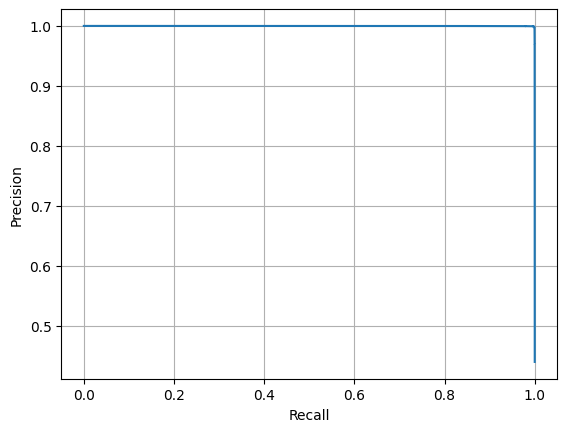

0.9998817378744044
0.9999344576035848


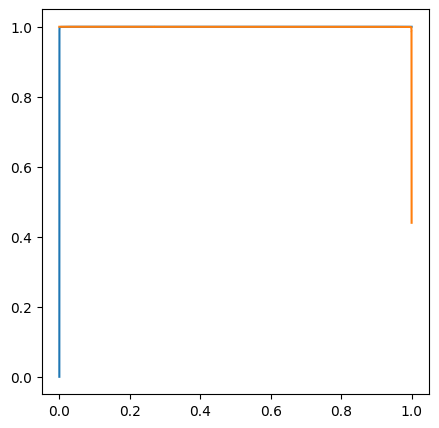

In [ ]:
from sklearn import metrics

# load data from dataset
#DATASET = 'network_data_h'
#DATASET = 'iiot_data_h'
""" raw_data, anomalous_raw, features, categorical_data_index = LoadDatasetByName(DATASET)
train_data, validation_data, test_data, anomalous_data = preProcessData_OneClass(raw_data, anomalous_raw, trim=trim_data, split=SPLIT, trim_threshold=0.98, normalize=normalize_data, normalization_scheme=normalization_scheme,
            filterLinearDependencies=filter_corrcoef, filter_threshold=0.98, removeNoise=remove_noise, noise_threshold=noise_threshold, return_dict=return_dict, discretize=False, categorical_data_index=categorical_data_index)
train_data, validation_data, test_data, anomalous_data = toTorchTensor(device, train_data, validation_data, test_data, anomalous_data)
 """
# load model
saved_model = '../model/param_'+model.name+'_'+DATASET
#saved_model = '../model/param_'+'AE''_'+'network_data_h'
#saved_model = '../model/param_'+'AE''_'+DATASET
#model.load_state_dict(torch.load(saved_model))

# 
loss_test, loss_attack = test_light(model, criterion, train_data, test_data, anomalous_data)
precision, recall, _ = metrics.precision_recall_curve(np.concatenate((np.zeros_like(loss_test), np.ones_like(loss_attack)), axis=0), np.concatenate((loss_test, loss_attack), axis=0))
fpr, tpr, _ = metrics.roc_curve(np.concatenate((np.zeros_like(loss_test), np.ones_like(loss_attack)), axis=0), np.concatenate((loss_test, loss_attack), axis=0))
disp = metrics.PrecisionRecallDisplay(precision=precision, recall=recall)
disp.plot()
plt.grid(visible=True)
#plt.xticks(np.arange(min(recall), max(recall), 0.1*(max(recall)-min(recall))))
plt.show()
print(metrics.auc(recall, precision))
print(metrics.auc(fpr, tpr))

fig = plt.figure(figsize = (5, 5))
ax = fig.add_subplot(1,1,1) 

ax.plot(fpr, tpr)
ax.plot(recall, precision)

In [ ]:
0.9871587315147174
0.9598632388444012

0.9598632388444012

In [ ]:
print("Feature-wise error threshold:\n------------------------------------------------")
print("MCC average: {:.4f}. MCC min: {:.4f}. MCC max: {:.4f}".format(np.mean(list(Enhanced_metrics["MCC"].values())), np.min(list(Enhanced_metrics["MCC"].values())), np.max(list(Enhanced_metrics["MCC"].values()))))
print("Specificity average: {:.2f}%. Specificity min: {:.2f}%. Specificity max: {:.2f}%".format(100*np.mean(list(Enhanced_metrics["Specificity"].values())), 100*np.min(list(Enhanced_metrics["Specificity"].values())), 100*np.max(list(Enhanced_metrics["Specificity"].values()))))
print("Recall average: {:.2f}%. Recall min: {:.2f}%. Recall max: {:.2f}%".format(100*np.mean(list(Enhanced_metrics["Recall"].values())), 100*np.min(list(Enhanced_metrics["Recall"].values())), 100*np.max(list(Enhanced_metrics["Recall"].values()))))

print("\nMSE error threshold:\n------------------------------------------------")
MCC_list = MCC(sensitivity=np.array(recall_list), specificity=np.array(specificity_list))
print("MCC average: {:.4f}. MCC min: {:.4f}. MCC max: {:.4f}".format(np.mean(MCC_list), np.min(MCC_list), np.max(MCC_list)))
print("specificity average: {:.2f}%. specificity min: {:.2f}%. specificity max: {:.2f}%".format(100*np.mean(specificity_list), 100*np.min(specificity_list), 100*np.max(specificity_list)))
print("recall average: {:.2f}%. recall min: {:.2f}%. recall max: {:.2f}%".format(100*np.mean(recall_list), 100*np.min(recall_list), 100*np.max(recall_list)))

Feature-wise error threshold:
------------------------------------------------
MCC average: 0.9657. MCC min: 0.9657. MCC max: 0.9657
Specificity average: 96.51%. Specificity min: 96.51%. Specificity max: 96.51%
Recall average: 100.00%. Recall min: 100.00%. Recall max: 100.00%

MSE error threshold:
------------------------------------------------
MCC average: 0.9500. MCC min: 0.9500. MCC max: 0.9500
specificity average: 94.87%. specificity min: 94.87%. specificity max: 94.87%
recall average: 100.00%. recall min: 100.00%. recall max: 100.00%


In [ ]:
# TEST
print(model.name)
th = 2
THRESHOLD_UPPER = 0.8
specificity_list, recall_list = torch.tensor(specificity_list), torch.tensor(recall_list)
f1_score_list = 2*specificity_list*recall_list/(specificity_list+recall_list)
mcc_list = MCC(specificity=specificity_list, sensitivity=recall_list)
print(mcc_list)
print(torch.min(mcc_list).item(), torch.max(mcc_list).item(), torch.mean(mcc_list).item())
#torch.max(specificity_list, dim=0)
criterion.reduction = 'none'

loss = criterion(model(train_data), train_data)
loss_threshold_per_feature = []
for i in range(train_data.shape[-1]):
    loss_threshold_per_feature.append(torch.sort(loss[:,i], dim=0)[0][int(len(train_data) * THRESHOLD_UPPER)-1].detach().clone())
loss_threshold_per_feature = torch.tensor(loss_threshold_per_feature)
print(loss_threshold_per_feature)
loss_std_per_feature = torch.std(loss, dim=0).detach().clone()
print(loss_std_per_feature)
loss = criterion(model(test_data), test_data)
print(1 - torch.sum(torch.sum(torch.greater(loss, loss_threshold_per_feature), dim=-1) > th, dim=0) / len(test_data))
#s
loss = criterion(model(anomalous_data), anomalous_data)
print()
print(torch.sum(torch.sum(torch.greater(loss, loss_threshold_per_feature), dim=-1) > th, dim=0) / len(anomalous_data))


AE
tensor([0.9500])
0.9499527215957642 0.9499527215957642 0.9499527215957642
tensor([1.5607e-05, 4.9640e-03, 6.6704e-06, 3.3336e-06, 8.0220e-05, 6.0553e-06,
        8.0270e-06, 6.7956e-05, 7.1679e-06, 1.2200e-04, 1.5923e-05, 1.6214e-05,
        1.1308e-04, 2.4981e-06, 7.1729e-05, 1.7834e-04, 9.3812e-05, 7.0338e-05,
        1.1199e-04, 4.7119e-05, 3.7775e-06, 6.8603e-05, 1.0011e-04, 3.4411e-05,
        4.9197e-05, 4.5598e-05, 6.6032e-03, 1.3825e-03, 2.9873e-05, 8.8638e-06,
        1.8368e-04, 1.4178e-05, 8.4231e-06])
tensor([1.8132e+01, 9.7247e-01, 2.7932e+01, 2.3205e+00, 1.1929e+01, 1.9558e+01,
        1.4956e+00, 6.5550e+01, 8.9689e-02, 1.5031e+01, 9.1364e-01, 1.3195e+00,
        2.9071e+00, 4.7678e+01, 1.6415e+00, 7.8368e+00, 7.5150e-01, 6.0647e+01,
        1.2434e+00, 3.6464e+00, 2.8150e+00, 3.0152e+00, 1.2443e+02, 4.0930e+00,
        4.0008e+00, 1.1081e+00, 7.0978e-01, 4.1784e+00, 1.6268e+01, 4.0414e-01,
        8.4841e+01, 1.5388e+01, 2.9536e+00])
tensor(0.2541)

tensor(1.)


In [ ]:
if False:
    anomalous_raw = np.loadtxt('../data/medical_attack_data_undetected.csv', skiprows=1, delimiter=',')[:,:-1]
    train_data, validation_data, test_data, anomalous_data = preProcessData_OneClass(raw_data, anomalous_raw, trim=trim_data, trim_threshold=0.98, normalize=normalize_data, normalization_scheme=normalization_scheme,
                filterLinearDependencies=filter_corrcoef, filter_threshold=0.98, removeNoise=remove_noise, noise_threshold=noise_threshold)
    train_data, validation_data, test_data, anomalous_data = toTorchTensor(device, train_data, validation_data, test_data, anomalous_data)
    train_loss, test_loss, attack_loss = getLoss(model, criterion, train_data, test_data, anomalous_data, weights=lcs_weights)
    print(torch.logical_or((attack_loss) > threshold_upper, (attack_loss) < threshold_lower))

In [ ]:
if False:
    anomalous_raw = np.loadtxt('../data/medical_attack_data.csv', skiprows=1, delimiter=',')[:,:-1]
    train_data, validation_data, test_data, anomalous_data = preProcessData_OneClass(raw_data, anomalous_raw, trim=trim_data, trim_threshold=0.98, normalize=normalize_data, normalization_scheme=normalization_scheme,
                filterLinearDependencies=filter_corrcoef, filter_threshold=0.98, removeNoise=remove_noise, noise_threshold=noise_threshold)
    train_data, validation_data, test_data, anomalous_data = toTorchTensor(device, train_data, validation_data, test_data, anomalous_data)
    train_loss, test_loss, attack_loss = getLoss(model, criterion, train_data, test_data, anomalous_data, weights=lcs_weights)
    print(torch.logical_or((attack_loss) > threshold_upper, (attack_loss) < threshold_lower))
    
th = 0
THRESHOLD_UPPER = 0.99

loss = criterion(model(train_data), train_data)
loss_threshold_per_feature = []
for i in range(train_data.shape[-1]):
    loss_threshold_per_feature.append(torch.sort(loss[:,i], dim=0)[0][math.floor(len(train_data) * THRESHOLD_UPPER)].detach().clone())
loss_threshold_per_feature = torch.tensor(loss_threshold_per_feature)
idc = torch.sum(torch.greater(loss, loss_threshold_per_feature), dim=-1) > th
print(1 - torch.sum(idc, dim=0) / len(train_data))
#s
anomalous_raw = np.loadtxt('../data/medical_attack_data_undetected.csv', skiprows=1, delimiter=',')[:,:-1]
idc = [2,4,5,6]
anomalous_raw = anomalous_raw[:,idc]
loss = criterion(model(anomalous_data), anomalous_data)
print()
print(torch.sum(torch.sum(torch.greater(loss, loss_threshold_per_feature), dim=-1) > th, dim=0) / len(anomalous_data))
idc = torch.sum(torch.greater(loss, loss_threshold_per_feature), dim=-1) <= th
print(idc.shape)
#network_undetected = np.loadtxt('../data/network_flow_attack_data.csv', skiprows=1, delimiter=',')[idc]
if False:
    np.savetxt('../data/idc/data_idc3.csv', (idc), delimiter=',')
print(idc.sum())
#print(network_undetected.shape)


tensor(0.9513)

tensor(1.)
torch.Size([87016])
tensor(0)


In [ ]:
if False:
    path = '../LCS_std'
    average, count = 0, 0
    for f in os.listdir(path):
        if os.path.splitext(f)[-1] == '.txt':
            average += np.loadtxt(os.path.join(path, f))
            count += 1
    np.savetxt(os.path.join(path+'_average', model.name+'_'+DATASET)+'.txt', average/count)

tensor(0.8879) tensor(1.)


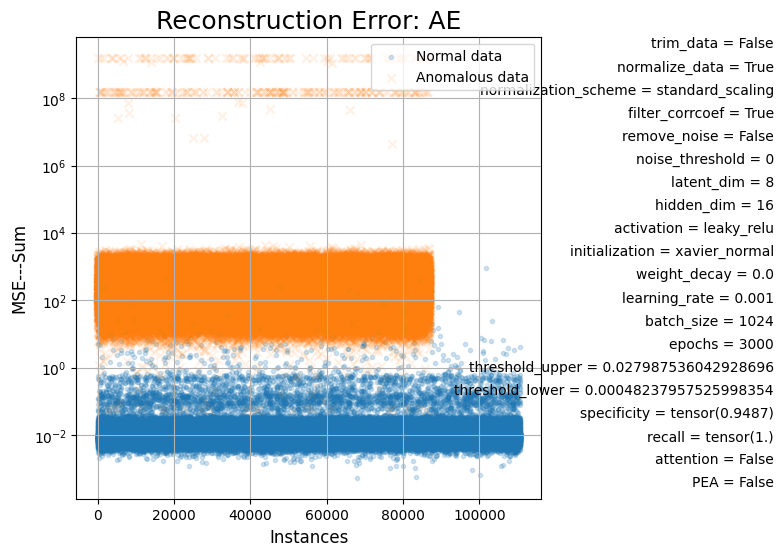

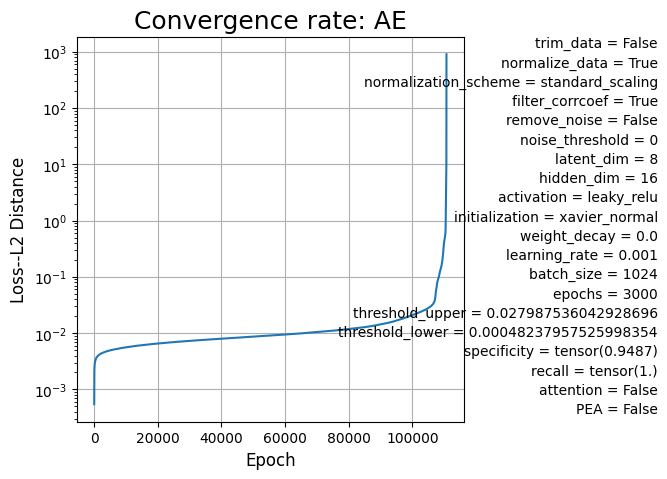

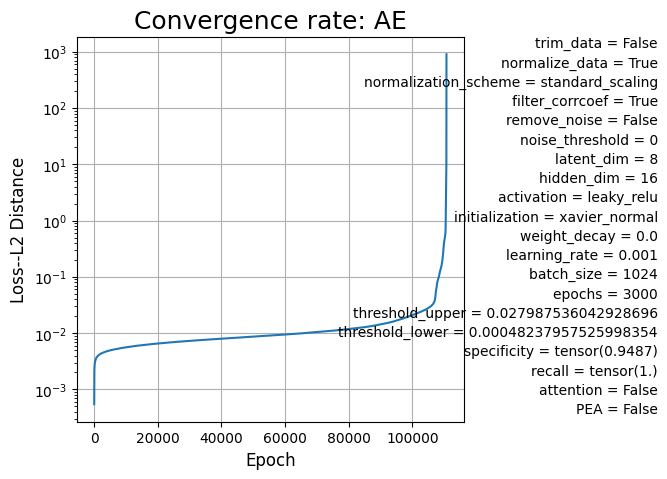

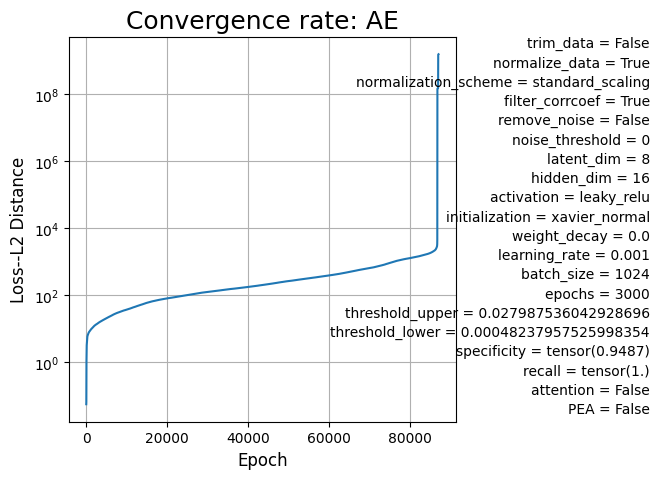

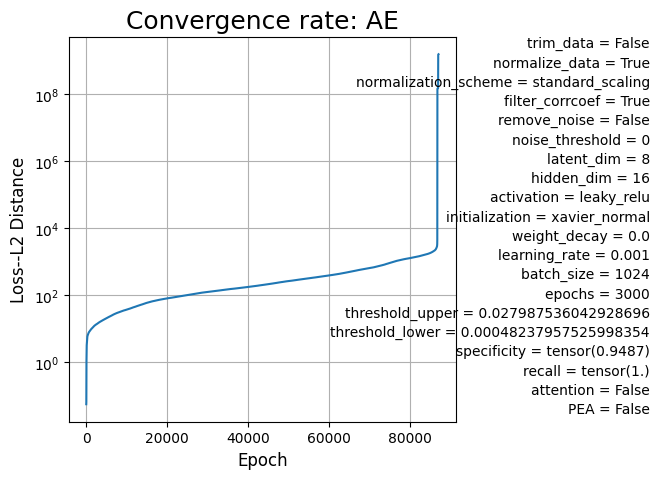

In [ ]:
visualize_loss(test_loss.detach().numpy(), attack_loss.detach().numpy(), model.name, save=False, **parameters)
sorted_loss_test, sorted_test_loss = torch.sort(torch.tensor(loss_test))[0], torch.sort(test_loss)[0]
sorted_loss_attack, sorted_attack_loss = torch.sort(torch.tensor(loss_attack))[0], torch.sort(attack_loss)[0]
visualize_convergence(sorted_loss_test, model.name, save=False, **parameters)
visualize_convergence(sorted_test_loss.detach(), model.name, save=False, **parameters)
visualize_convergence(sorted_loss_attack, model.name, save=False, **parameters)
visualize_convergence(sorted_attack_loss.detach(), model.name, save=False, **parameters)
sorted_loss, _ = torch.sort(torch.sum((model(train_data)-train_data)**2, dim=1, keepdim=False))
threshold = sorted_loss[math.floor(len(sorted_loss)*0.89)]
precision = torch.sum(torch.sum((model(test_data)-test_data)**2, dim=1) <= threshold) / len(test_data)
recall = torch.sum(torch.sum((model(anomalous_data)-anomalous_data)**2, dim=1) > threshold) / len(anomalous_data)
print(precision, recall)

In [ ]:
if False:
    raw_data = np.loadtxt('../data/iiot_og.csv', dtype=str, delimiter=',')
    l = (raw_data.shape[-1])
    idc = [i for i in range(l) if i not in (0, 1, 2, 3, l-2)]
    raw_data = raw_data[:,idc]
    #np.savetxt('../data/iiot.csv', X=raw_data, delimiter=',', fmt='%s')
    
    idc = np.int32(raw_data[1:,-1]) == 1
    idc = np.append(True, idc)
    idc.shape
    idc.sum()
    np.savetxt('../data/iiot_attack_data.csv', X=raw_data[idc], delimiter=',', fmt='%s')
    raw_data = np.loadtxt('../data/iiot.csv', dtype=str, delimiter=',', max_rows=1)

In [ ]:
#np.savetxt(fname='../1/predicted_price.csv', X=predicted_vol)

In [ ]:
#model = model = AutoEncoder(num_feature=num_feature, latent_dim=8, hidden_dim=16, activation=activation, initialization=initialization).to(device)
total_params = sum(p.numel() for p in model.parameters())
print(f"Number of parameters: {total_params}")

Number of parameters: 53449
